In [1]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
from tensorflow.python.util import deprecation

deprecation._PRINT_DEPRECATION_WARNINGS = False

import scipy.io
import os
import sys
import time
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from datetime import datetime

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from PIL import ImageOps
from PIL import Image
from skimage.filters import threshold_otsu
import sklearn.metrics as mt
from sklearn.model_selection import train_test_split
import numpy as np

import tensorflow as tf
from tensorflow import keras
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

from skimage.measure import block_reduce
from scipy.ndimage import zoom
from skimage.color import rgb2gray
from skimage.io import imread,imshow
from skimage.transform import resize
from scipy import ndimage as morph
import argparse
import math
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import create_pairwise_bilateral
from pydensecrf.utils import create_pairwise_gaussian
from pdb import set_trace as bp


DATASET = 1
PRE_TRAIN = 0
TRAIN = 1
NAME_DATASET = ["Texas", "California"]
USE_PATCHES = 0  # DATASET

SEN12_OPT_PATH="Data/Sen12/Optical/"
SEN12_SAR_PATH="Data/Sen12/Sar/"


PATCH_SIZE = 100


W_REG = 0.001
W_TRAN = 5.0
W_CYCLE = 4.0
MAX_GRAD_NORM = 1.0
DROP_PROB = 0.1
ALPHA_LEAKY = 0.3

CHANNELS_SAR=1
CHANNELS_OPT=3



np.random.seed(41148)

nf1 = 100
nf2 = 50
nf3 = 20
nf4 = 10

fs1 = 3
fs2 = 3
fs3 = 3
fs4 = 3

nc1 = 11
nc2 = 3

specs_X_to_Y = [
    [nc1, nf1, fs1, 1],
    [nf1, nf2, fs2, 1],
    [nf2, nf3, fs3, 1],
    [nf3, nc2, fs4, 1],
]

specs_Y_to_X = [
    [nc2, nf1, fs1, 1],
    [nf1, nf2, fs2, 1],
    [nf2, nf3, fs3, 1],
    [nf3, nc1, fs4, 1],
]
sen12_specs_X_to_Y = [
    [1, nf1, fs1, 1],
    [nf1, nf2, fs2, 1],
    [nf2, nf3, fs3, 1],
    [nf3, 3, fs4, 1],
]

sen12_specs_Y_to_X = [
    [3, nf1, fs1, 1],
    [nf1, nf2, fs2, 1],
    [nf2, nf3, fs3, 1],
    [nf3, 1, fs4, 1],
]

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    file_names=list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            names,files=getListOfFiles(fullPath)
            allFiles = allFiles + files
            file_names=file_names+names
        else:
            allFiles.append(fullPath)
            file_names.append(entry)
                
    return file_names,allFiles

In [3]:
def findnth(string, substring, n):
    """find nth occurence of substring"""
    parts = string.split(substring, n + 1)
    if len(parts) <= n + 1:
        return -1
    return len(string) - len(parts[-1]) - len(substring)

In [4]:
class Sen12DataGenerator(keras.utils.Sequence):
    "data generator for the supervised training of the translation model"
    def __init__(self,
                 list_IDs,
                 optpath,
                 sarpath,
                 batch_size,
                 dim,
                 n_channels_x,
                 n_channels_y,
                 to_fit=True,
                 shuffle=True):
        
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels_x = n_channels_x
        self.n_channels_y = n_channels_y
        self.optpath=optpath
        self.sarpath=sarpath
        self.shuffle = shuffle
        self.to_fit=to_fit
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y,prior = self.__data_generation(list_IDs_temp)

        return X, Y, prior

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels_x))
        Y = np.empty((self.batch_size, *self.dim, self.n_channels_y))

        # Generate data
        for i, ID_x in enumerate(list_IDs_temp):
            
            ID_y=ID_x.replace("_s1_","_s2_")
            
            ind1=findnth(ID_x,"_",1)+1
            ind2=findnth(ID_x,"_",3)
            
            x_dir=ID_x[ind1:ind2]
            y_dir=ID_y[ind1:ind2]
            
            
            tmp_x=imread(os.path.join(self.sarpath,x_dir,ID_x))
            tmp_x=resize(tmp_x,(PATCH_SIZE,PATCH_SIZE))
            tmp_x=np.reshape(tmp_x,(PATCH_SIZE,PATCH_SIZE,self.n_channels_x))
            
            
            tmp_y=imread(os.path.join(self.optpath,y_dir,ID_y))
            tmp_y=resize(tmp_y,(PATCH_SIZE,PATCH_SIZE))
            tmp_y=np.reshape(tmp_y,(PATCH_SIZE,PATCH_SIZE,self.n_channels_y))
            
            X[i,] = (tmp_x-1)*2
            Y[i,] = (tmp_y-1)*2

        return X,Y,(np.zeros((PATCH_SIZE,PATCH_SIZE,CHANNELS_SAR)),np.zeros((PATCH_SIZE,PATCH_SIZE,CHANNELS_OPT)))

In [5]:
def network(specs,name):
    """returns sequential convolutional model with specs"""
    
    net_input=tf.keras.Input(shape=(PATCH_SIZE,PATCH_SIZE,specs[0][0]),name=name+"_input")
    out=net_input
    for i,l in enumerate(specs):
        out=tf.keras.layers.Conv2D(specs[i][1],specs[i][2],activation=None,padding="same")(out)
        out=tf.keras.layers.LeakyReLU(alpha=ALPHA_LEAKY)(out)
        if i!=(len(specs)-1):
            out=tf.keras.layers.Dropout(DROP_PROB)(out)
        else:
            out=tf.keras.activations.tanh(out)
    model=keras.Model(inputs=net_input,outputs=out,name=name)
    return model

In [6]:
def xnetLoss(x,y,xhat,yhat,xcycle,ycycle,parameters,prior_x,prior_y):
    """weighted loss of the Xnet model according to prior"""
    
    trans_loss_x= tf.compat.v1.losses.mean_squared_error(x, xhat, weights=1.0-prior_x[None,:,:,:])
    trans_loss_y= tf.compat.v1.losses.mean_squared_error(y, yhat, weights=1.0-prior_y[None,:,:,:])
    cycle_loss_x= tf.compat.v1.losses.mean_squared_error(x, xcycle, weights=1.0-prior_x[None,:,:,:])
    cycle_loss_y= tf.compat.v1.losses.mean_squared_error(y, ycycle, weights=1.0-prior_y[None,:,:,:])
    
    reg_loss = tf.add_n(tf.reduce_mean(tf.nn.l2_loss(v)) for v in parameters)
    
    tot_loss_x = (
                W_CYCLE * cycle_loss_x
                + W_TRAN * trans_loss_x
            )

    tot_loss_y = (
                W_CYCLE * cycle_loss_y
                + W_TRAN * trans_loss_y
            )
    return tot_loss_x+tot_loss_y+ W_REG * reg_loss

In [7]:
class Xnet(keras.Model):
    def __init__(self, xynet,yxnet,inputs,outputs,name,**kwargs):
        super(Xnet, self).__init__(inputs=inputs,outputs=outputs,name=name)
        self.xynet=xynet
        self.yxnet=yxnet
        self.parameters=self.trainable_variables
        
    def compile(self,optimizer,loss_fn):
        super(Xnet, self).compile(optimizer=optimizer,loss=loss_fn)
        self.optimizer=optimizer
        self.loss_fn=loss_fn

    def train_step(self,data):
        xpatch,ypatch,prior=data
        prior_x,prior_y=prior
        with tf.GradientTape() as tape:
            yhat,xhat,xcycle,ycycle=self(data,training=True)
            tot_loss=xnetLoss(xpatch,ypatch,xhat,yhat,xcycle,ycycle,self.parameters,prior_x,prior_y)
        grads=tape.gradient(tot_loss,self.parameters)
        clipped_grads, _ = tf.clip_by_global_norm(grads, MAX_GRAD_NORM)
        self.optimizer.apply_gradients(zip(clipped_grads, self.parameters))
        return {"loss": tot_loss}
        
    def test_step(self,data):
        xpatch,ypatch,prior=data
        prior_x,prior_y=prior
        yhat,xhat,xcycle,ycycle=self(data,training=True)
        tot_loss=xnetLoss(xpatch,ypatch,xhat,yhat,xcycle,ycycle,self.parameters,prior_x,prior_y)
        return {"loss": tot_loss}
    
    def __call__(self,data,training=False):
        xpatch,ypatch,prior=data
        xhat=self.yxnet(ypatch)
        yhat=self.xynet(xpatch)
        if training:
            xcycle=self.yxnet(yhat)
            ycycle=self.xynet(xhat)
            return yhat,xhat,xcycle,ycycle
        else:
            return yhat,xhat
            

In [8]:
LEARNING_RATE = 10e-3
EPOCHS = 1000
BATCH_SIZE = 32

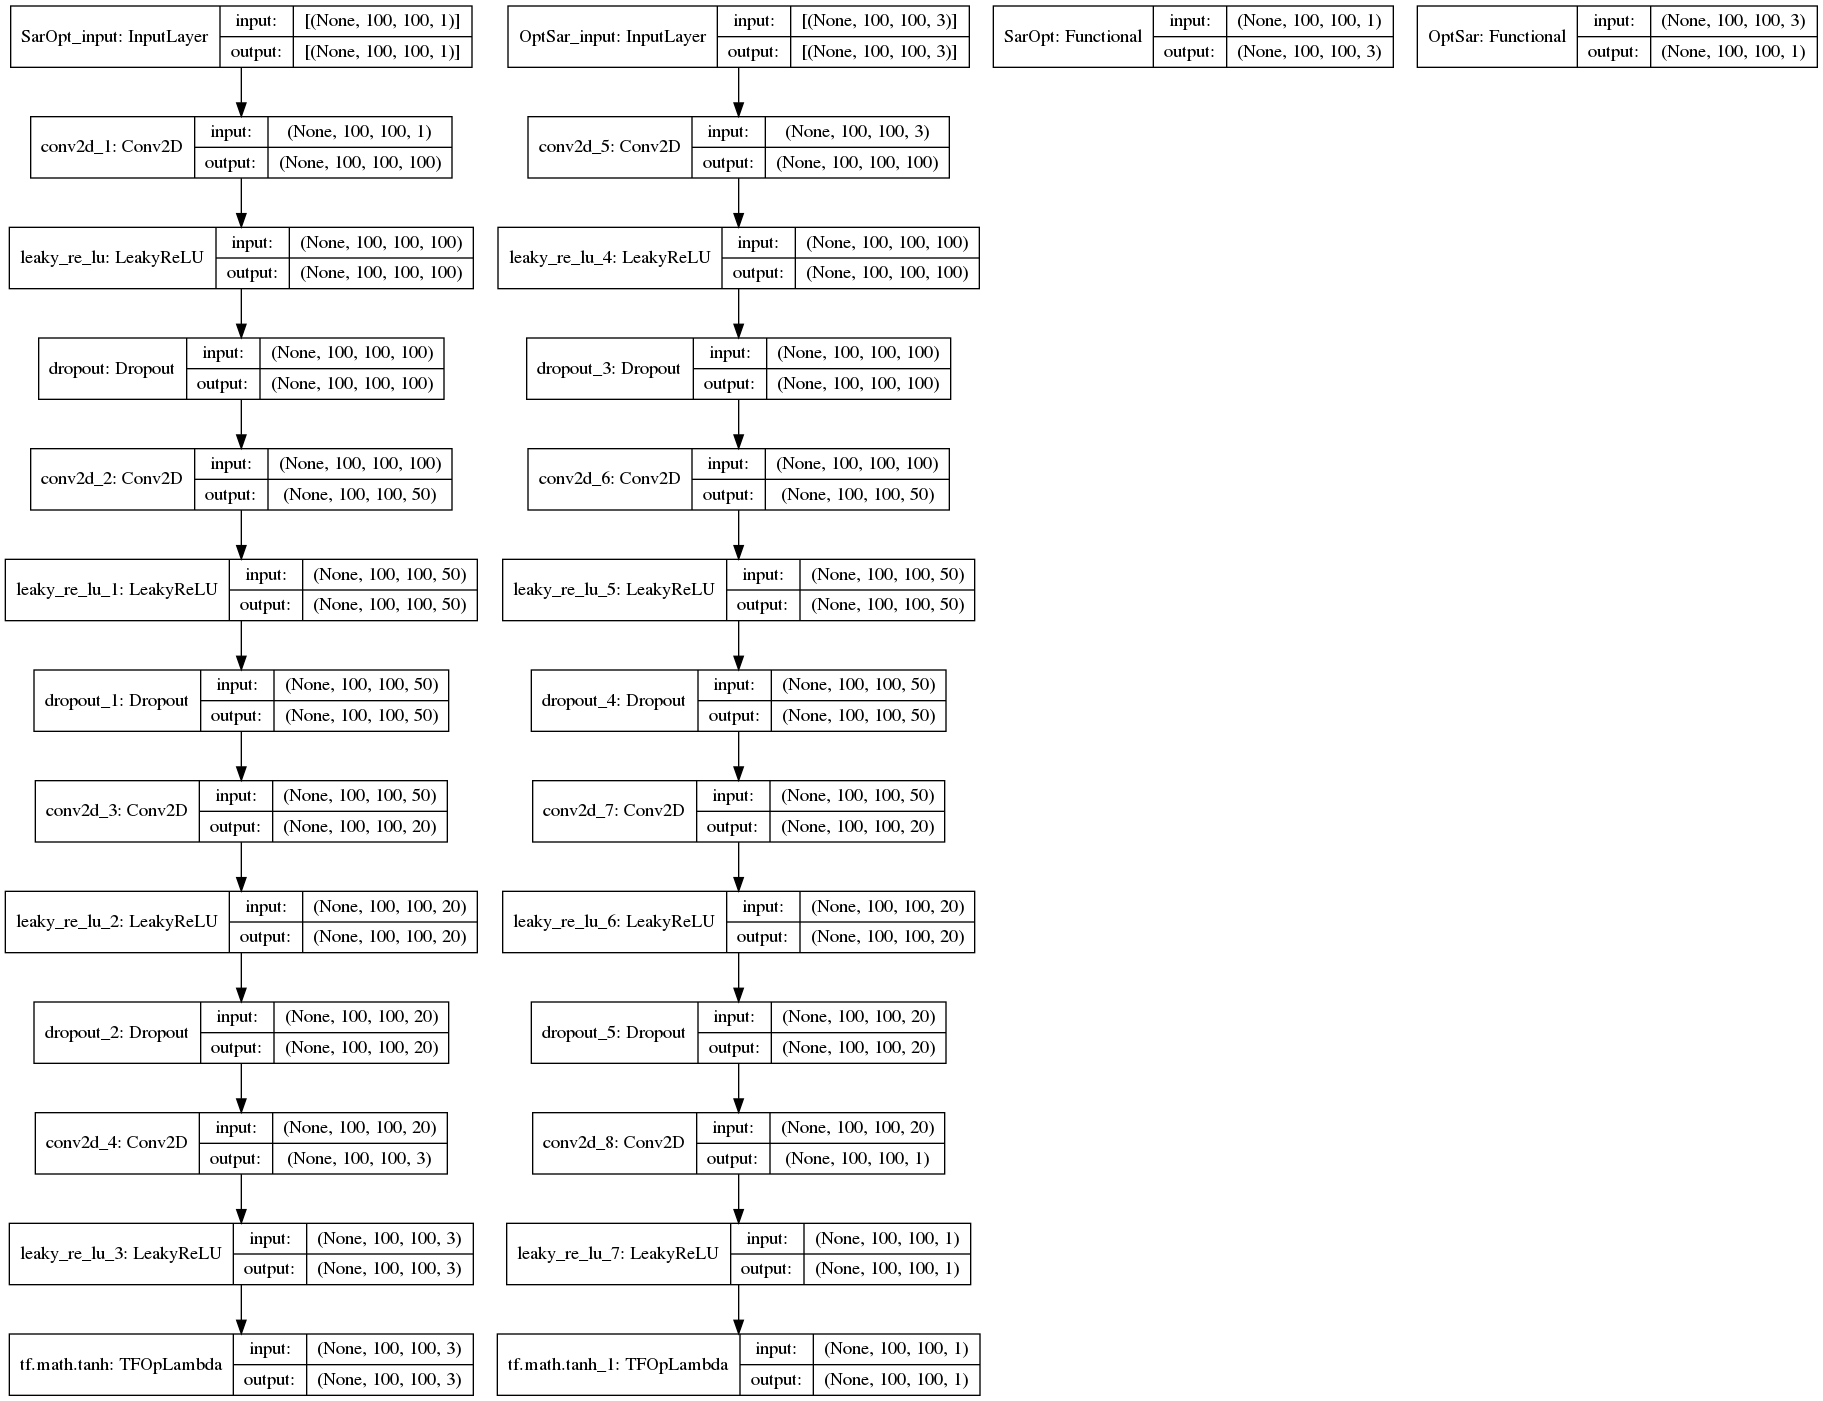

In [10]:
#get two component convolutional networks and build Xnet model

netSarOpt=network(sen12_specs_X_to_Y,"SarOpt")
netOptSar=network(sen12_specs_Y_to_X,"OptSar")
xnet=Xnet(xynet=netSarOpt,yxnet=netOptSar,inputs=[netSarOpt.input,netOptSar.input],outputs=[netSarOpt.output,netOptSar.output],name="Sen12_Xnet")
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
xnet.compile(optimizer=optimizer,loss_fn=xnetLoss)
tf.keras.utils.plot_model(xnet, to_file="model.png", show_shapes=True)

In [11]:
#create train and validation translation data generators

list_IDs,_ = getListOfFiles("Data/Sen12/Sar")
train_list_IDs ,valid_list_IDs = train_test_split(list_IDs,test_size=0.2,shuffle=True)
saropt_train_gen=Sen12DataGenerator(train_list_IDs,SEN12_OPT_PATH,SEN12_SAR_PATH,BATCH_SIZE,(PATCH_SIZE,PATCH_SIZE),CHANNELS_SAR,CHANNELS_OPT,True,False)
saropt_valid_gen=Sen12DataGenerator(valid_list_IDs,SEN12_OPT_PATH,SEN12_SAR_PATH,BATCH_SIZE,(PATCH_SIZE,PATCH_SIZE),CHANNELS_SAR,CHANNELS_OPT,True,False)

In [11]:
cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'experiments_dir')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_name = 'sen12_xnet'

exp_dir = os.path.join(exps_dir, exp_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
              filepath=os.path.join(ckpt_dir,'mymodel_{epoch}'),
              save_best_only=False,
              save_weights_only=True,
              verbose=1)

callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)


# Early Stopping Callback
# ------------------------
es_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
callbacks.append(es_callback)

# Reduce Learning Rate On Plateau
# -------------------------------
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                   factor=0.1,
                                                   patience=3,
                                                   min_lr=0.000001,
                                                   verbose=1)
callbacks.append(lr_callback)

# Fit model
# ---------
xnet.fit(saropt_train_gen,
         validation_data=saropt_valid_gen,
         epochs=EPOCHS,
         callbacks=callbacks)

Epoch 1/1000
3230/3230 [==============================] - 5758s 2s/step - loss: 4.2502 - val_loss: 3.2781

Epoch 00001: saving model to /home/infamouskz/Projects2CourseWork/IACV/Project/experiments_dir/sen12_xnet_Feb10_21-49-51/ckpts/mymodel_1
Epoch 2/1000
3230/3230 [==============================] - 6234s 2s/step - loss: 4.3775 - val_loss: 3.2963

Epoch 00002: saving model to /home/infamouskz/Projects2CourseWork/IACV/Project/experiments_dir/sen12_xnet_Feb10_21-49-51/ckpts/mymodel_2
Epoch 3/1000
3230/3230 [==============================] - 6056s 2s/step - loss: 4.3236 - val_loss: 3.2795

Epoch 00003: saving model to /home/infamouskz/Projects2CourseWork/IACV/Project/experiments_dir/sen12_xnet_Feb10_21-49-51/ckpts/mymodel_3
Epoch 4/1000
3230/3230 [==============================] - 6145s 2s/step - loss: 4.3829 - val_loss: 3.2789

Epoch 00004: saving model to /home/infamouskz/Projects2CourseWork/IACV/Project/experiments_dir/sen12_xnet_Feb10_21-49-51/ckpts/mymodel_4

Epoch 00004: ReduceLROn

In [12]:
def save_image(array, folder):
    """save array as image in folder"""
    
        img = Image.fromarray(array.astype("uint8"))
        if folder.find("Aff") != -1 or folder.find("d") != -1:
            img = ImageOps.equalize(img, mask=None)
        img = img.convert("RGB")
        img.save(folder)

In [13]:
def filtering(d,sar,opt):
    """apply filtering to difference array"""
    
        # print("Filtering!")
        d = d[..., np.newaxis]
        d = np.concatenate((d, 1.0 - d), axis=2)
        W = np.size(d, 0)
        H = np.size(d, 1)
        stack = np.dstack((sar,opt))
        CD = dcrf.DenseCRF2D(W, H, 2)
        d[d == 0] = 10e-20
        U = -(np.log(d))
        U = U.transpose(2, 0, 1).reshape((2, -1))
        U = U.copy(order="C")
        CD.setUnaryEnergy(U.astype(np.float32))
        pairwise_energy_gaussian = create_pairwise_gaussian((10, 10), (W, H))
        CD.addPairwiseEnergy(pairwise_energy_gaussian, compat=1)
        pairwise_energy_bilateral = create_pairwise_bilateral(
            sdims=(10, 10), schan=(0.1,), img=stack, chdim=2
        )
        CD.addPairwiseEnergy(pairwise_energy_bilateral, compat=1)
        Q = CD.inference(3)
        heatmap = np.array(Q)
        heatmap = np.reshape(heatmap[0, ...], (W, H))
        return heatmap

In [14]:
class TestDataGenerator(keras.utils.Sequence):
    "Generate patches from test images with corresponding prior patches"
    
    def __init__(self,
                 opt,
                 sar,
                 prior_sar,
                 prior_opt,
                 patch_size,
                 batch_size,
                 dim,
                 n_channels_x,
                 n_channels_y,
                 to_fit=True,
                 shuffle=True):
        
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels_x = n_channels_x
        self.n_channels_y = n_channels_y
        self.patch_size=patch_size
        self.opt=opt
        self.sar=sar
        self.prior_opt=opt
        self.prior_sar=sar
        self.shuffle = shuffle
        self.to_fit=to_fit
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((self.opt.shape[0]/self.patch_size)*(self.opt.shape[1]/self.patch_size) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        patch_size=self.patch_size
        # Find list of IDs
        list_coords_temp = [((k//(self.opt.shape[1]/self.patch_size)*self.patch_size),(k%(self.opt.shape[1]/self.patch_size)*self.patch_size)) for k in indexes]
        
        # Generate data
        X, Y,prior = self.__data_generation(list_coords_temp)

        return X, Y, prior

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(np.floor((self.opt.shape[0]/self.patch_size)*(self.opt.shape[1]/self.patch_size)))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_coords_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        patch_size=self.patch_size
        X = np.empty((self.batch_size, *self.dim, self.n_channels_x))
        Y = np.empty((self.batch_size, *self.dim, self.n_channels_y))
        prior_x= np.empty((*self.dim, self.n_channels_x))
        prior_y= np.empty((*self.dim, self.n_channels_y))               
        # Generate data
        for i, coords in enumerate(list_coords_temp):
            coord_1,coord_3=coords
            coord_1=int(coord_1)
            coord_3=int(coord_3)
            coord_2=coord_1+patch_size
            coord_4=coord_3+patch_size
            X[i,] = self.sar[coord_1:coord_2,coord_3:coord_4,:]
            Y[i,] = self.opt[coord_1:coord_2,coord_3:coord_4,:]
            prior_x=self.prior_sar[coord_1:coord_2,coord_3:coord_4,:]
            prior_y=self.prior_opt[coord_1:coord_2,coord_3:coord_4,:]
            
        return X,Y,(prior_x,prior_y)

In [15]:
def get_prior(xnet,opt,sar):
    """get prior map from test image using trained translation model"""
    
    n_channels=sar.shape[2]
    x_hat=np.zeros_like(sar[:,:,0])
    y_hat=np.zeros_like(opt)
    d_x=np.zeros_like(sar)
    d_y=d_x
    prior_x=np.zeros((PATCH_SIZE,PATCH_SIZE,1))
    prior_y=np.zeros((PATCH_SIZE,PATCH_SIZE,3))
    for channel in range(n_channels):
        tmp_sar=sar[:,:,channel]
        print(channel)
        for i in range(0,opt.shape[0],PATCH_SIZE):
            for j in range(0,opt.shape[1],PATCH_SIZE):
                tmp_y,tmp_x=xnet((tmp_sar[None,i:i+PATCH_SIZE,j:j+PATCH_SIZE],opt[None,i:i+PATCH_SIZE,j:j+PATCH_SIZE,:],(prior_x,prior_y)),False)
                x_hat[i:i+PATCH_SIZE,j:j+PATCH_SIZE]=tmp_x[:,:,0]
                y_hat[i:i+PATCH_SIZE,j:j+PATCH_SIZE,:]=tmp_y
        d_x[:,:,channel]=abs(tmp_sar - x_hat)
        tmp=opt-y_hat
        d_y[:,:,channel]=np.linalg.norm(tmp, 2, -1)

    d_x=np.min(d_x,axis=2)
    d_y=np.min(d_y,axis=2)
    
    d_x[d_x > np.mean(d_x) + 3.0 * np.std(d_x)] = np.mean(d_x) + 3.0 * np.std(d_x)
    d_y[d_y > np.mean(d_y) + 3.0 * np.std(d_y)] = np.mean(d_y) + 3.0 * np.std(d_y)
    d_x = d_x / np.max(d_x)
    d_y = d_y / np.max(d_y)
    
    d_x=np.repeat(d_x[:, :, np.newaxis], nc1, axis=2)
    d_y=np.repeat(d_y[:, :, np.newaxis], nc2, axis=2)
            
    return d_x,d_y

In [16]:
xnet.load_weights("experiments_dir/sen12_xnet_Feb10_21-49-51/ckpts/mymodel_13")

In [17]:
LEARNING_RATE = 10e-5
EPOCHS = 240
W_REG = 0.001
W_TRAN = 3.0
W_CYCLE = 2.0
MAX_GRAD_NORM = 1.0
DROP_PROB = 0.2
ALPHA_LEAKY = 0.3

In [18]:
#load test data and generate prior map

mat = scipy.io.loadmat("Data/UiT_HCD_California_2017.mat")
sar = np.array(mat["t1_L8_clipped"], dtype=float)
opt = np.array(mat["logt2_clipped"], dtype=float)
mask = np.array(mat["ROI"], dtype=bool)
prior_sar,prior_opt=get_prior(xnet,opt,sar)

0
1
2
3
4
5
6
7
8
9
10


In [19]:
#create test data generator
test_gen = TestDataGenerator(opt,
                             sar,
                             prior_sar,
                             prior_opt,
                             PATCH_SIZE,
                             1,
                             (PATCH_SIZE,PATCH_SIZE),
                             nc1,
                             nc2,
                             to_fit=True,
                             shuffle=True)

In [20]:
#build component models and transfer weights from translation model

netSarOpt_test=network(specs_X_to_Y,"SarOpt_test")
netOptSar_test=network(specs_Y_to_X,"OptSar_test")

for i,layer in enumerate(netSarOpt.layers):
    if i>2 and ("conv" in layer.name):
        netSarOpt_test.get_layer(index=i).set_weights(layer.get_weights())
        

for i,layer in enumerate(netOptSar.layers):
    if i<len(netOptSar.layers)-3 and ("conv" in layer.name):
        netOptSar_test.get_layer(index=i).set_weights(layer.get_weights())

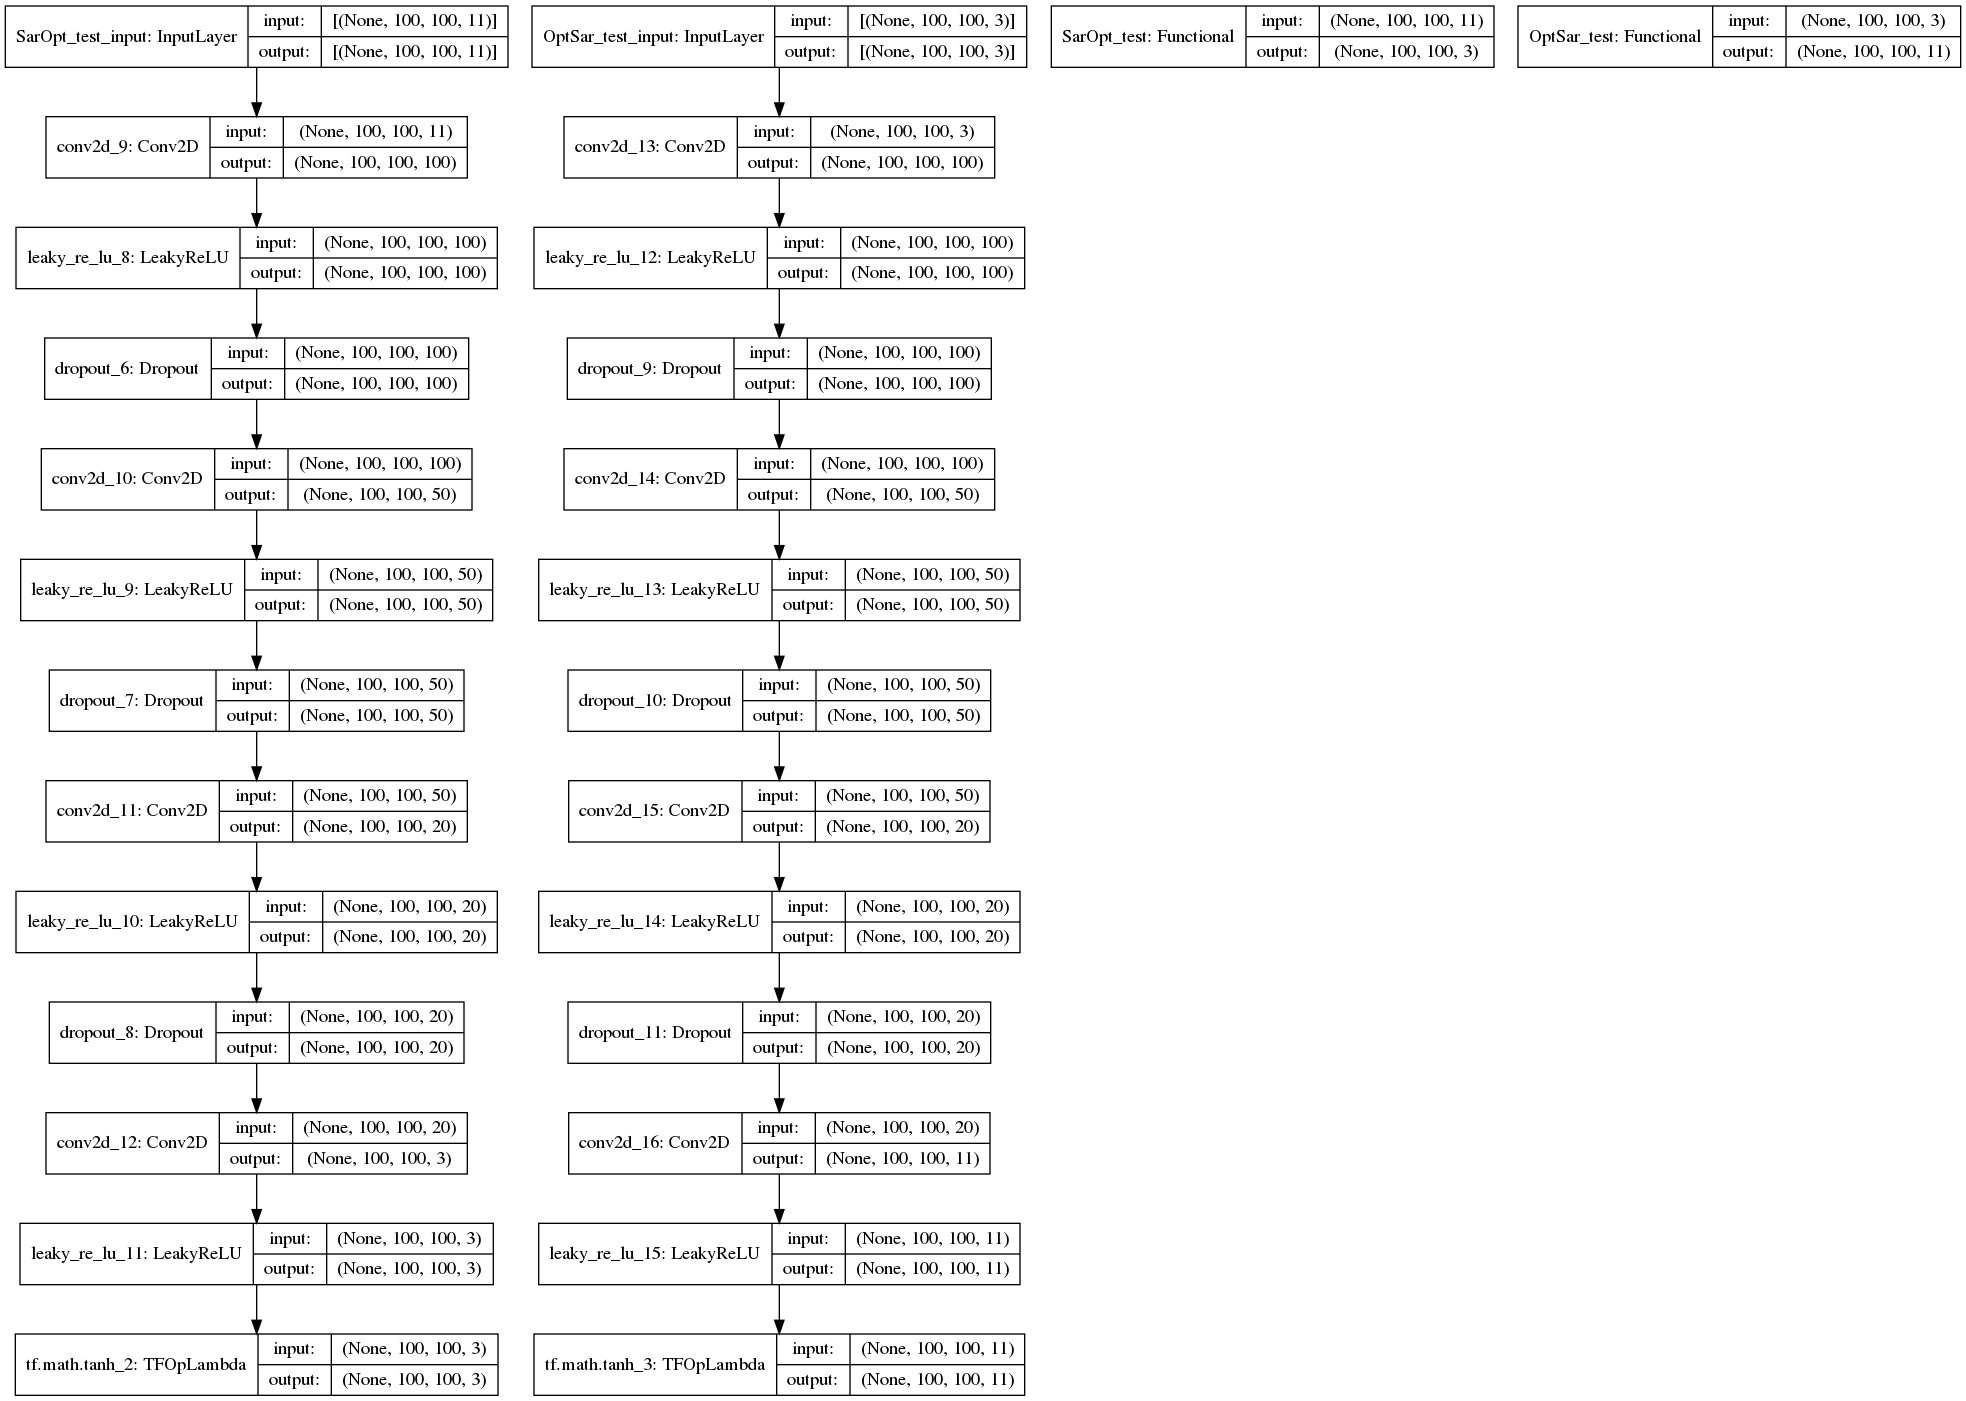

In [21]:
#build final change detection model to be trained on test data with exponential decay learning rate

xnet_full=Xnet(xynet=netSarOpt_test,yxnet=netOptSar_test,inputs=[netSarOpt_test.input,netOptSar_test.input],outputs=[netSarOpt_test.output,netOptSar_test.output],name="Test_Xnet")
lr=tf.keras.optimizers.schedules.ExponentialDecay(LEARNING_RATE, 10000, 0.96, staircase=True)
optimizer = tf.keras.optimizers.Adam(lr)
xnet_full.compile(optimizer=optimizer,loss_fn=xnetLoss)
tf.keras.utils.plot_model(xnet_full, to_file="model.png", show_shapes=True)

In [25]:
cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'experiments_dir')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_name = 'test_xnet'

exp_dir = os.path.join(exps_dir, exp_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
callbacks = []
# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
              filepath=os.path.join(ckpt_dir,'mymodel_{epoch}'),
              save_best_only=False,
              save_weights_only=True,
              verbose=1)

callbacks.append(ckpt_callback)


# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

xnet_full.fit(test_gen,
         epochs=EPOCHS,
         callbacks=callbacks)

Epoch 1/240
700/700 [==============================] - 35s 44ms/step - loss: 0.7963

Epoch 00001: saving model to /home/infamouskz/Projects2CourseWork/IACV/Project/experiments_dir/test_xnet_Feb12_02-47-13/ckpts/mymodel_1
Epoch 2/240
700/700 [==============================] - 31s 44ms/step - loss: 0.4355

Epoch 00002: saving model to /home/infamouskz/Projects2CourseWork/IACV/Project/experiments_dir/test_xnet_Feb12_02-47-13/ckpts/mymodel_2
Epoch 3/240
700/700 [==============================] - 32s 46ms/step - loss: 0.4179

Epoch 00003: saving model to /home/infamouskz/Projects2CourseWork/IACV/Project/experiments_dir/test_xnet_Feb12_02-47-13/ckpts/mymodel_3
Epoch 4/240
700/700 [==============================] - 33s 47ms/step - loss: 0.4086

Epoch 00004: saving model to /home/infamouskz/Projects2CourseWork/IACV/Project/experiments_dir/test_xnet_Feb12_02-47-13/ckpts/mymodel_4
Epoch 5/240
700/700 [==============================] - 33s 48ms/step - loss: 0.3925

Epoch 00005: saving model to /h

In [22]:
xnet_full.load_weights("experiments_dir/test_xnet_Feb12_02-47-13/ckpts/mymodel_240")

In [23]:
def evaluate(xnet,opt,sar,mask,save,save_path):
    """generate change map of test data and evaluate model performance"""
    
    x_hat=np.zeros_like(sar)
    y_hat=np.zeros_like(opt)
    d_x=x_hat
    d_y=y_hat
    prior_x=np.zeros((PATCH_SIZE,PATCH_SIZE,1))
    prior_y=np.zeros((PATCH_SIZE,PATCH_SIZE,3))

    for i in range(0,opt.shape[0],PATCH_SIZE):
        for j in range(0,opt.shape[1],PATCH_SIZE):
            tmp_y,tmp_x=xnet((sar[None,i:i+PATCH_SIZE,j:j+PATCH_SIZE,:],opt[None,i:i+PATCH_SIZE,j:j+PATCH_SIZE,:],(prior_x,prior_y)),False)
            x_hat[i:i+PATCH_SIZE,j:j+PATCH_SIZE]=tmp_x
            y_hat[i:i+PATCH_SIZE,j:j+PATCH_SIZE,:]=tmp_y
    
    d_x=sar-x_hat
    d_y=opt-y_hat
    
    d_x = np.linalg.norm(d_x, 2, -1)
    d_y = np.linalg.norm(d_y, 2, -1)
    
    d_x[d_x > np.mean(d_x) + 3.0 * np.std(d_x)] = np.mean(d_x) + 3.0 * np.std(d_x)
    d_y[d_y > np.mean(d_y) + 3.0 * np.std(d_y)] = np.mean(d_y) + 3.0 * np.std(d_y)
    d_x = d_x / np.max(d_x)
    d_y = d_y / np.max(d_y)
    d = (d_x + d_y) / 2.0
    
    heatmap = filtering(d,sar,opt)
    otsu = threshold_otsu(heatmap) 
    CD_map = heatmap >= otsu 
    CD_map=morph.binary_opening(CD_map,structure=np.ones((5,5)))
    
    conf_map = np.zeros_like(CD_map)
    conf_map = np.tile(conf_map[..., np.newaxis], (1, 1, 3))
    conf_map[np.logical_and(mask, CD_map)] = [1, 1, 1]
    conf_map[np.logical_and(mask, np.logical_not(CD_map)), :] = [1, 0, 0]
    conf_map[np.logical_and(np.logical_not(mask), CD_map), :] = [0, 1, 0]
    
    if save:
        save_image(255.0 * d_x, save_path+"d_x.png")
        save_image(255.0 * d_y, save_path+"d_y.png")
        save_image(255.0 * d, save_path+"d.png")
        save_image(255.0 * heatmap, save_path+"d_filtered.png")
        save_image(255.0 * conf_map, save_path+"Confusion_map.png")
        save_image(255.0 * (sar[..., 1:4] + 1.0) / 2.0, save_path+"x.png")
        save_image(255.0 * (x_hat[..., 1:4] + 1.0) / 2.0, save_path+"x_hat.png")
        save_image(255.0 * (opt + 1.0) / 2.0, save_path+"y.png")
        save_image(255.0 * (y_hat + 1.0) / 2.0, save_path+"y_hat.png")
        
    AUC = mt.roc_auc_score(mask.flatten(), heatmap.flatten())
    AUPRC = mt.average_precision_score(mask.flatten(), heatmap.flatten())

    PREC_0 = mt.precision_score(mask.flatten(), CD_map.flatten(), pos_label=0)
    PREC_1 = mt.precision_score(mask.flatten(), CD_map.flatten())
    REC_0 = mt.recall_score(mask.flatten(), CD_map.flatten(), pos_label=0)
    REC_1 = mt.recall_score(mask.flatten(), CD_map.flatten())
    KC = mt.cohen_kappa_score(mask.flatten(), CD_map.flatten())
    [[TN, FP], [FN, TP]] = mt.confusion_matrix(
        mask.flatten(), CD_map.flatten()
    )
    evaluation = {"TP":TP,
                  "TN":TN,
                  "FP":FP,
                  "FN":FN,
                  "PREC_0":PREC_0,
                  "REC_0":REC_0,
                  "PREC_1":PREC_1,
                  "REC_1":REC_1,
                  "KC":KC,
                  "AUC":AUC,
                  "AUPRC":AUPRC}
    return evaluation

In [24]:
evaluate(xnet_full,opt,sar,mask,True,"Outputs/Fine/")

{'TP': 189835,
 'TN': 6356683,
 'FP': 337390,
 'FN': 116092,
 'PREC_0': 0.9820645704508499,
 'REC_0': 0.9495986972355993,
 'PREC_1': 0.36006448859595047,
 'REC_1': 0.6205238504610577,
 'KC': 0.4238341154143964,
 'AUC': 0.8921877842254892,
 'AUPRC': 0.35119281228355054}